In [ ]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:

# !pip install --upgrade numpy==1.22.0

comp = 'paddy-doctor/paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')


In [3]:
path

Path('../input/paddy-doctor/paddy-disease-classification')

In [4]:
from fastai.vision.all import *
set_seed(42)

path.ls()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(#6) [Path('../input/paddy-doctor/paddy-disease-classification/sample_submission.csv'),Path('../input/paddy-doctor/paddy-disease-classification/train_images'),Path('../input/paddy-doctor/paddy-disease-classification/.jovianrc'),Path('../input/paddy-doctor/paddy-disease-classification/.ipynb_checkpoints'),Path('../input/paddy-doctor/paddy-disease-classification/train.csv'),Path('../input/paddy-doctor/paddy-disease-classification/test_images')]

In [5]:
trn_path=path/'train_images'
files=get_image_files(trn_path)

(480, 640)


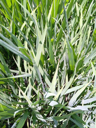

In [6]:
img=PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [7]:
from fastcore.parallel import * 

def f(o): return PILImage.create(o).size
sizes= parallel(f, files, n_workers= 8)
pd.Series(sizes).value_counts()

(480, 640)    10407
Name: count, dtype: int64

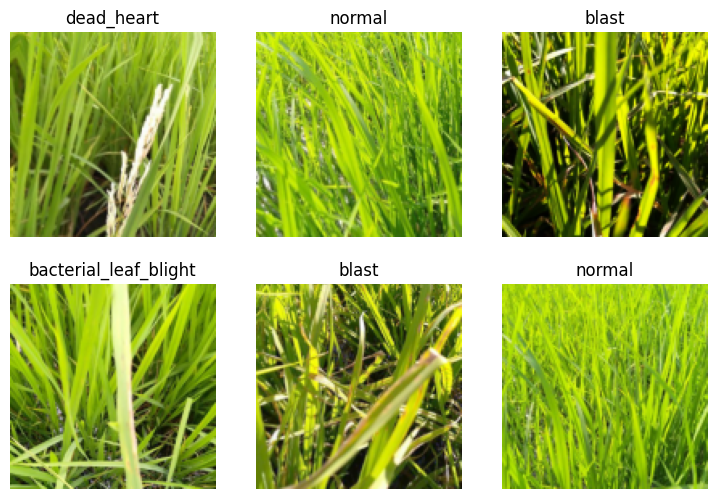

In [8]:
dls= ImageDataLoaders.from_folder(trn_path, valid_pct = 0.2, seed= 42, 
    item_tfms= Resize(256, method='Squish'),
    batch_tfms= aug_transforms(size=128, min_scale=0.75))
dls.show_batch(max_n=6)

In [9]:
learn= vision_learner(dls, ' resnet26d', metrics= error_rate, path='.').to_fp16()


SuggestedLRs(valley=0.0008317637839354575, slide=0.0063095735386013985)

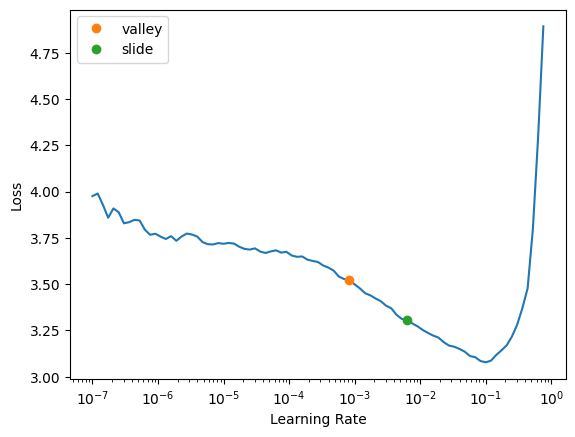

In [10]:

learn.lr_find(suggest_funcs=(valley, slide))


In [11]:
learn.fine_tune(3,0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.900018,1.508921,0.481980,00:36


epoch,train_loss,valid_loss,error_rate,time
0,1.244700,0.850289,0.283037,00:37
1,0.861714,0.514502,0.171072,00:38
2,0.650888,0.470945,0.150408,00:38


In [12]:
ss= pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [13]:
tst_files= get_image_files(path/'test_images').sorted()
tst_dl= dls.test_dl(tst_files)

In [14]:
probs,_, idxs= learn.get_preds(dl= tst_dl, with_decoded= True)
idxs

tensor([7, 7, 6,  ..., 8, 1, 5])

In [15]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [16]:
mapping= dict(enumerate(dls.vocab))
results= pd.Series(idxs.numpy(),name= 'idxs').map(mapping)
results

0                       hispa
1                       hispa
2                downy_mildew
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [17]:
ss['label']=results
ss.to_csv('subm.csv',index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,hispa
200003.jpg,downy_mildew
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [18]:
# if not iskaggle:
#     from kaggle import api
#     api.competition_submit_cli('subm.csv','initial rn26d 128px', comp)

In [19]:
# if not iskaggle:
#     push_notebook('Mayank','Intial',
#                  title= 'Initial',
#                  file= 'Initial',
#                  competition= comp, private= False, gpu= True)

In [20]:
# ?push_notebook

In [21]:
# # filenames=test_gen.filenames

# # results=pd.DataFrame({"image_id":filenames,
# #                       "label":predictions})
# # results.image_id = results.image_id.str.replace('./', '')
# # results.to_csv("submission.csv",index=False)
# # results.head()

# filenames = tst_dl.items

# results = pd.DataFrame({"tst_files": filenames, "label": tst_dl.argmax(dim=-1)})
# results.image_id = results.image_id.str.replace('./', '')
# results.to_csv("submission.csv", index=False)
# results.head()


In [22]:
# preds = learn.get_preds(dl=tst_dl)[0]
# predicted_labels = preds.argmax(dim=-1)
# decoded_labels = tst_dl.vocab[predicted_labels]
# results = pd.DataFrame({"tst_files": tst_dl.items, "label": decoded_labels})
# results['tst_files'] = results['tst_files'].str.replace('./', '')
# results.to_csv("submission.csv", index=False)


In [23]:
# preds = learn.get_preds(dl=tst_dl)[0]
# predicted_labels = preds.argmax(dim=-1)
# decoded_labels = tst_dl.vocab[predicted_labels]
# results = pd.DataFrame({"tst_files": tst_dl.items, "label": decoded_labels})
# results['tst_files'] = results['tst_files'].str.replace('./', '')
# results.to_csv("submission.csv", index=False)
